# NLP Standard Project:

- Students: **Matteo Belletti**, **Alessandro Pasi**, **Stricescu Razvan Ciprian**.

The Standard Project is about addressing this task: Emotion Discovery and Reasoning its Flip in Conversation (EDiReF), SemEval 2024 Task 10, SUBTASK iii (English only) 

### Libraries and dependencies:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
import random
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.utils import class_weight
import pandas as pd
import json
import transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, f1_score
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(f"Device: {device}")

C:\Users\alepa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


In order to better assess the project we trained and evaluated our models on five different seeds. The results are reported in the report but also in the notebook in the section "Results".

Seed selection:

In [2]:
#RANDOM_SEED = 42
#RANDOM_SEED = 2
#RANDOM_SEED = 4
#RANDOM_SEED = 22
RANDOM_SEED = 420
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
transformers.set_seed(RANDOM_SEED)

## Data loading and preprocessing:

The data contains 4000 short English dialogues from the TV show "Friends". Each dialogue is composed of different sentences, each of which is annotated with a label that indicates the emotion expressed by the speaker and whether it triggers that emotion or not.

The labels for emotion are: 
| Emotion: | neutral | joy | sadness | fear | anger | suprise | disgust |
|----------|---------|-----|---------|------|-------|---------|---------|

The labels for trigger are:
| Trigger: | 0 | 1 |
|----------|---------|-----|


The data is loaded and preprocessed as follows:

In [3]:
# open json in project_data_MELD folder
try:
    with open('project_data_MELD/MELD_train_efr.json') as f: # Modify this path to your local path
        data = json.load(f)
except:
    with open('MELD_train_efr.json') as f:
        data = json.load(f)
print(f"Number of samples: {len(data)}")
print(f"Example of a sample: {data[0]}")

Number of samples: 4000
Example of a sample: {'episode': 'utterance_0', 'speakers': ['Chandler', 'The Interviewer', 'Chandler', 'The Interviewer', 'Chandler'], 'emotions': ['neutral', 'neutral', 'neutral', 'neutral', 'surprise'], 'utterances': ["also I was the point person on my company's transition from the KL-5 to GR-6 system.", "You must've had your hands full.", 'That I did. That I did.', "So let's talk a little bit about your duties.", 'My duties?  All right.'], 'triggers': [0.0, 0.0, 0.0, 1.0, 0.0]}


In order to easily load the data we used the pandas library. The data is loaded from the list previously created and then it is converted into a pandas dataframe. 

We also drop the episode column, which functions as an index, as it is not useful for our task.

In [4]:
# Convert data to pandas dataframe
df = pd.DataFrame(data)
# Drop episode and speakers columns
df = df.drop(columns=['episode'])
print(f"Dataframe shape: {df.shape}")
print(f"Dataframe columns: {df.columns}")
print(f"Dataframe head:\n {df.head(1)}")

Dataframe shape: (4000, 4)
Dataframe columns: Index(['speakers', 'emotions', 'utterances', 'triggers'], dtype='object')
Dataframe head:
                                             speakers  \
0  [Chandler, The Interviewer, Chandler, The Inte...   

                                         emotions  \
0  [neutral, neutral, neutral, neutral, surprise]   

                                          utterances  \
0  [also I was the point person on my company's t...   

                    triggers  
0  [0.0, 0.0, 0.0, 1.0, 0.0]  


The trigger column also contains NaN values, which we replace with 0.0 in order to avoid errors during the training phase.

In [5]:
count = 0
for row in df["triggers"]:
    for elem in row:
        if elem != 1 and elem != 0:
            count += 1
print("Number of NaN values in the triggers column: {}".format(count))
print("Example of a sample with NaN values:")
print(df["triggers"][3359])
df["triggers"] = df["triggers"].apply(lambda x: [0 if elem != 1 and elem != 0 else elem for elem in x])
print("Example of a sample after removing the NaN values:")
print(df["triggers"][3359])

Number of NaN values in the triggers column: 9
Example of a sample with NaN values:
[0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
Example of a sample after removing the NaN values:
[0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]


The data is then split into train, test and validation sets, with a 80/10/10 ratio.

In [6]:
# Split data
from sklearn.model_selection import train_test_split

df_train, temp = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(temp, test_size=0.5, random_state=RANDOM_SEED)
print(f"Train shape: {df_train.shape}")
print(f"Val shape: {df_val.shape}")
print(f"Test shape: {df_test.shape}")

Train shape: (3200, 4)
Val shape: (400, 4)
Test shape: (400, 4)


In order to better assess the data we also plot the distribution of the labels in the train set so that we can see if there is a class imbalance.

In [7]:
# first we create a dictionary of all emotions with their corresponding occurences
emotions_dict = {}
for emotions in df_train["emotions"]:
    for emotion in emotions:
        if emotion in emotions_dict:
            emotions_dict[emotion] += 1
        else:
            emotions_dict[emotion] = 1

# then we sort the dictionary by occurences
emotions_dict = {k: v for k, v in sorted(emotions_dict.items(), key=lambda item: item[1], reverse=True)}
print("Emotions sorted by occurences:")
print(emotions_dict)

Emotions sorted by occurences:
{'neutral': 12247, 'joy': 4971, 'surprise': 3734, 'anger': 3144, 'sadness': 2061, 'fear': 866, 'disgust': 823}


In [8]:
# This function is only used to better visualize plots by setting a random color for each element, so it's just for aesthetic purposes
def set_color(number_of_colors):
    # return a random color to be used for the plot
    color_list = []
    for i in range(number_of_colors):
        color_list.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return color_list

Plotting the distribution of emotions.

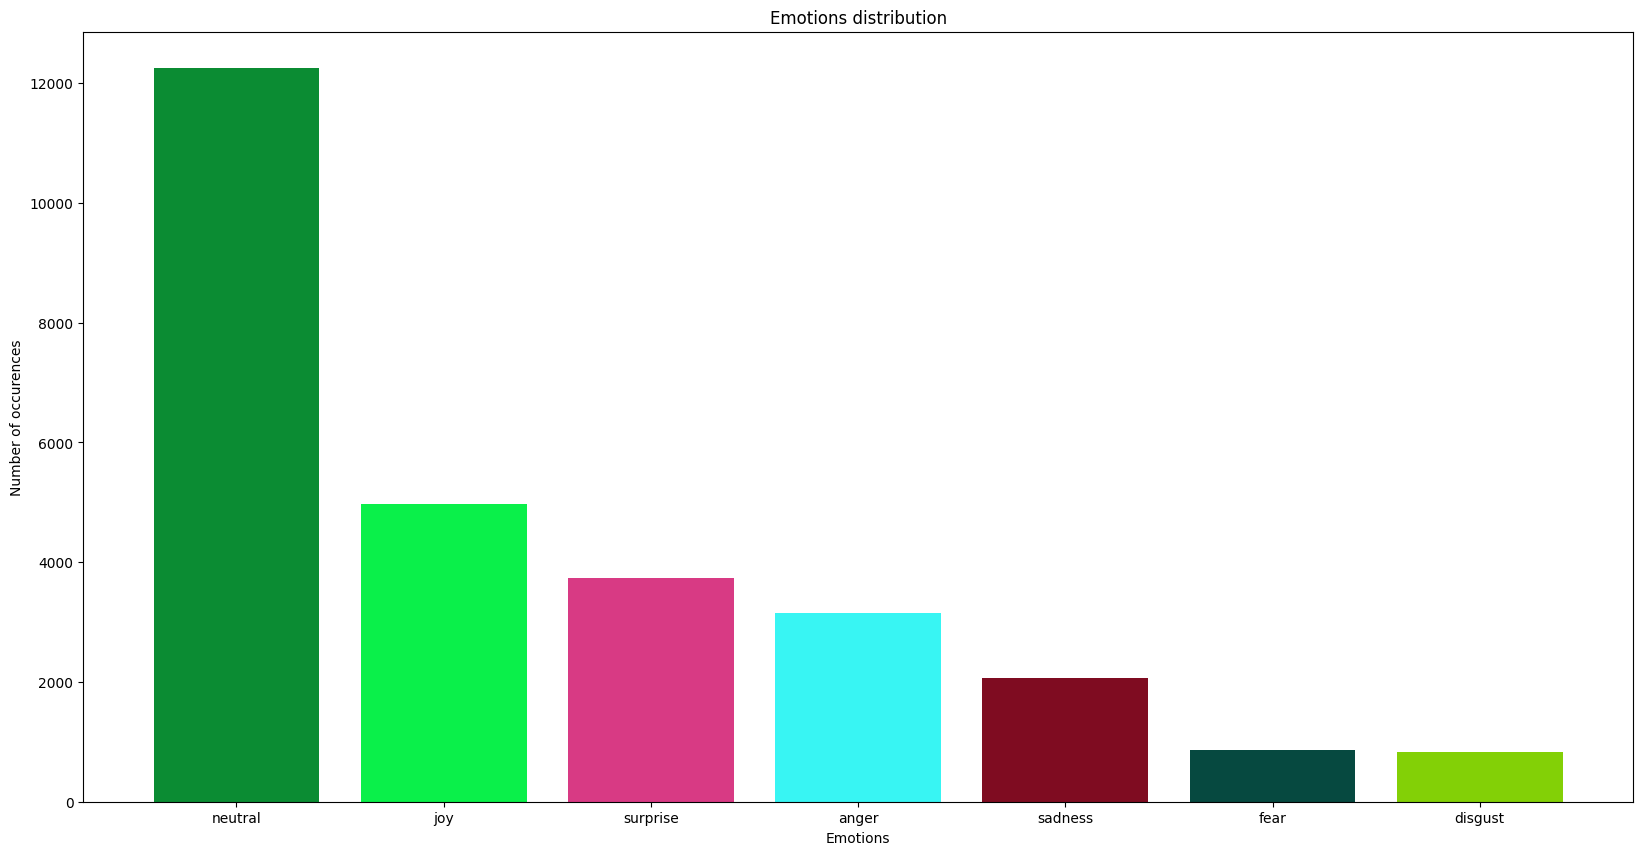

In [9]:
# plot the emotions distribution as histogram
plt.figure(figsize=(20,10))
plt.bar(emotions_dict.keys(), emotions_dict.values(), color=set_color(len(emotions_dict)))
plt.title("Emotions distribution")
plt.xlabel("Emotions")
plt.ylabel("Number of occurences")
plt.show()

As we can see from the plot, the data is not balanced, with the neutral class being the most represented and the disgust class being the least represented. This could lead to problems during the training phase, as the model could be biased towards the neutral class.

We will adress this problem later on in this part of the notebook.

Triggers sorted by occurences:
{0.0: 23428, 1.0: 4418}


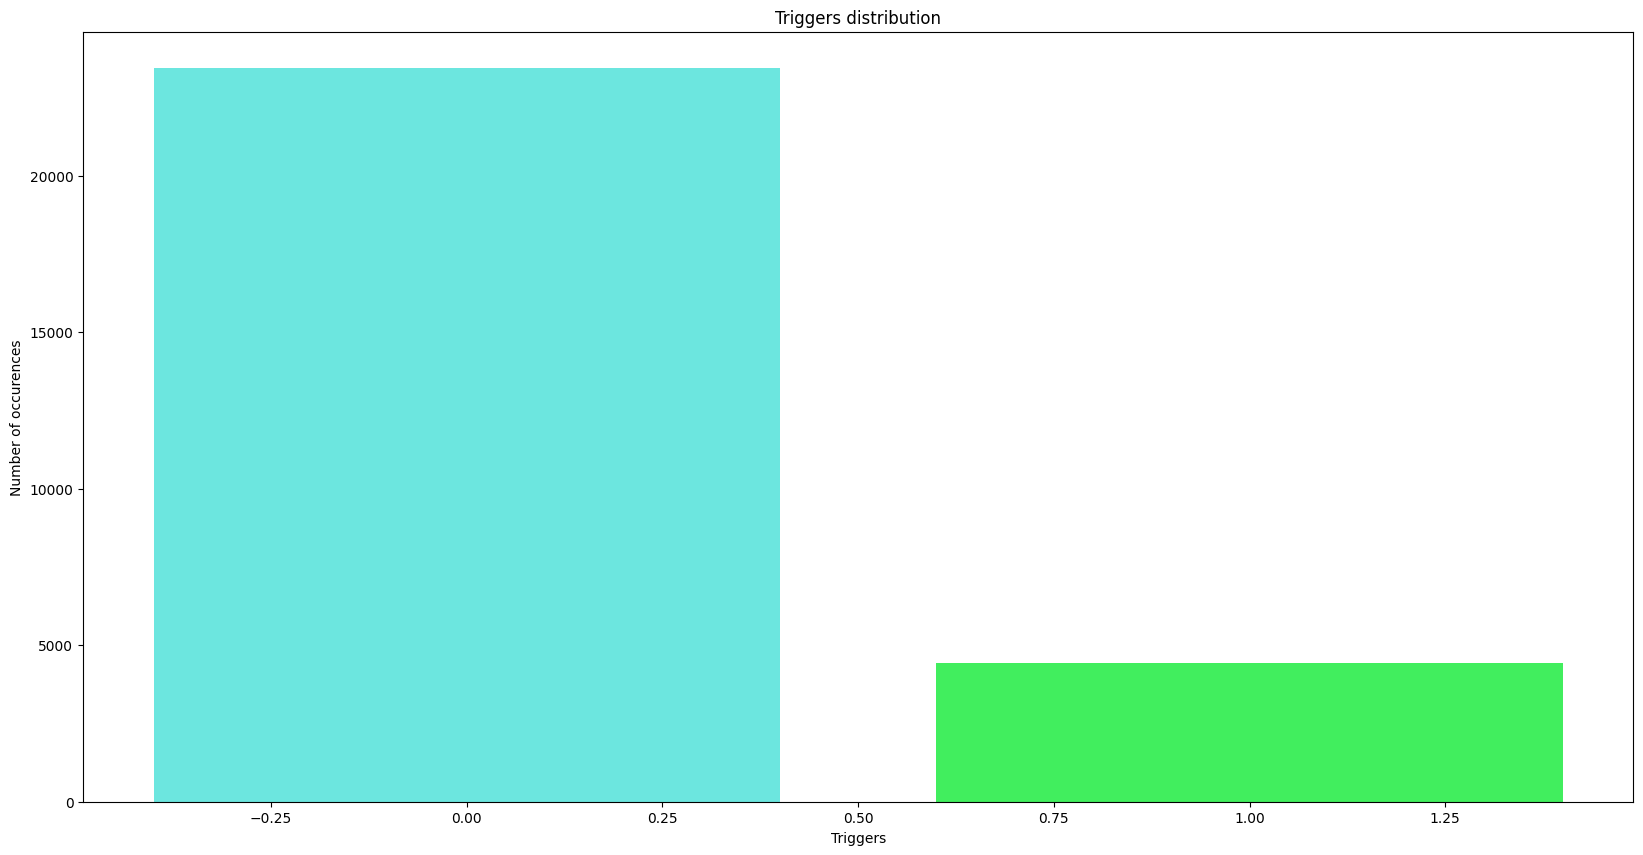

In [10]:
# trigger distribution
trigger_dict = {}
for triggers in df_train["triggers"]:
    for trigger in triggers:
        if trigger in trigger_dict:
            trigger_dict[trigger] += 1
        else:
            trigger_dict[trigger] = 1
        
trigger_dict = {k: v for k, v in sorted(trigger_dict.items(), key=lambda item: item[1], reverse=True)}
print("Triggers sorted by occurences:")
print(trigger_dict)

# plot the triggers distribution as histogram
plt.figure(figsize=(20,10))
plt.bar(trigger_dict.keys(), trigger_dict.values(), color=set_color(len(trigger_dict)))
plt.title("Triggers distribution")
plt.xlabel("Triggers")
plt.ylabel("Number of occurences")
plt.show()

Likewise, we plot the distribution of the trigger labels and we notice that the data is not balanced, with the 0 class being the most represented and the 1 class being the least represented. This could lead to problems during the training phase, as the model could be biased towards the 0 class.

We will adress this problem later on in this part of the notebook.

### Prepocessing:

As we present two different macro type of models, we will preprocess the data in two different ways.

*Baseline models*: Dummy classfiers with random uniform and majority strategies.

*BeRT models*: Frozen and unfrozen models based on the BeRT architecture with an additional multihead classifier layers. 

#### Baseline models:

For the baselines models we implement some text processing techniques such as lemmatization, stop words removal, etc. In this case we will use nltk library for lemmatization and stop words removal.

In [11]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
#stop_words = set(stopwords.words('english'))
bad_symbols = re.compile('[^a-z ]')
punct = string.punctuation

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alepa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alepa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alepa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\alepa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [12]:
def preprocess_text(text):
    text = bad_symbols.sub('', text)
    text = word_tokenize(text) 
    text = [lemmatizer.lemmatize(word) for word in text] 
    text = ' '.join(text)
    return text

In [13]:
baseline_train = df_train.copy()
baseline_train["utterances"] = baseline_train["utterances"].apply(lambda x: [preprocess_text(elem) for elem in x])
baseline_test = df_test.copy()
baseline_test["utterances"] = baseline_test["utterances"].apply(lambda x: [preprocess_text(elem) for elem in x])
baseline_val = df_val.copy()
baseline_val["utterances"] = baseline_val["utterances"].apply(lambda x: [preprocess_text(elem) for elem in x])
print("Example of a sample after preprocessing:")
print(baseline_train["utterances"][0])

Example of a sample after preprocessing:
['also wa the point person on my company transition from the to system', 'ou mustve had your hand full', 'hat did hat did', 'o let talk a little bit about your duty', 'y duty ll right']


In order to use the TF-IDF vectorizer we need to split the utterances into single sentences, likewise the emotions and triggers.

In [14]:
def splitter(df, y_label):
    X = []
    y = []
    for index, row in df.iterrows():
        for i in range(len(row["utterances"])):
            X.append(row["utterances"][i])
            y.append(row[y_label][i])
    return X, y

In [15]:
# Emotions baseline
x_train_base, y_train_emotions = splitter(baseline_train, "emotions")
x_val_base, y_val_emotions = splitter(baseline_val, "emotions")
x_test_base, y_test_emotions = splitter(baseline_test, "emotions")

# Triggers baseline
_ , y_train_triggers = splitter(baseline_train, "triggers")
_ , y_val_triggers = splitter(baseline_val, "triggers")
_ , y_test_triggers = splitter(baseline_test, "triggers")

print(f"Train shape after splitting: {len(x_train_base)}")
print(f"Val shape after splitting: {len(x_val_base)}")
print(f"Test shape after splitting: {len(x_test_base)}")

print("Example of a sample after splitting: sentence, emotion, trigger")
print(x_train_base[0], y_train_emotions[0], y_train_triggers[0])

Train shape after splitting: 27846
Val shape after splitting: 3614
Test shape after splitting: 3540
Example of a sample after splitting: sentence, emotion, trigger
eah neutral 0.0


As a tokenizer we use TfidfVectorizer from sklearn. We also use the tokenizer to create the vocabulary for the embeddings.

In [16]:
vectorizer = TfidfVectorizer()

x_train_base = vectorizer.fit_transform(x_train_base)
x_val_base = vectorizer.transform(x_val_base)
x_test_base = vectorizer.transform(x_test_base)

print(f"Train shape after vectorization: {x_train_base.shape}")
print(f"Val shape after vectorization: {x_val_base.shape}")
print(f"Test shape after vectorization: {x_test_base.shape}")

print(f"Size of the vocabulary: {len(vectorizer.vocabulary_)}")

Train shape after vectorization: (27846, 5168)
Val shape after vectorization: (3614, 5168)
Test shape after vectorization: (3540, 5168)
Size of the vocabulary: 5168


#### BeRT models:

Before proceeding with the preprocessing of the data, we inspect the data in order to visualize different aspects of it.

Max number of sentences: 24


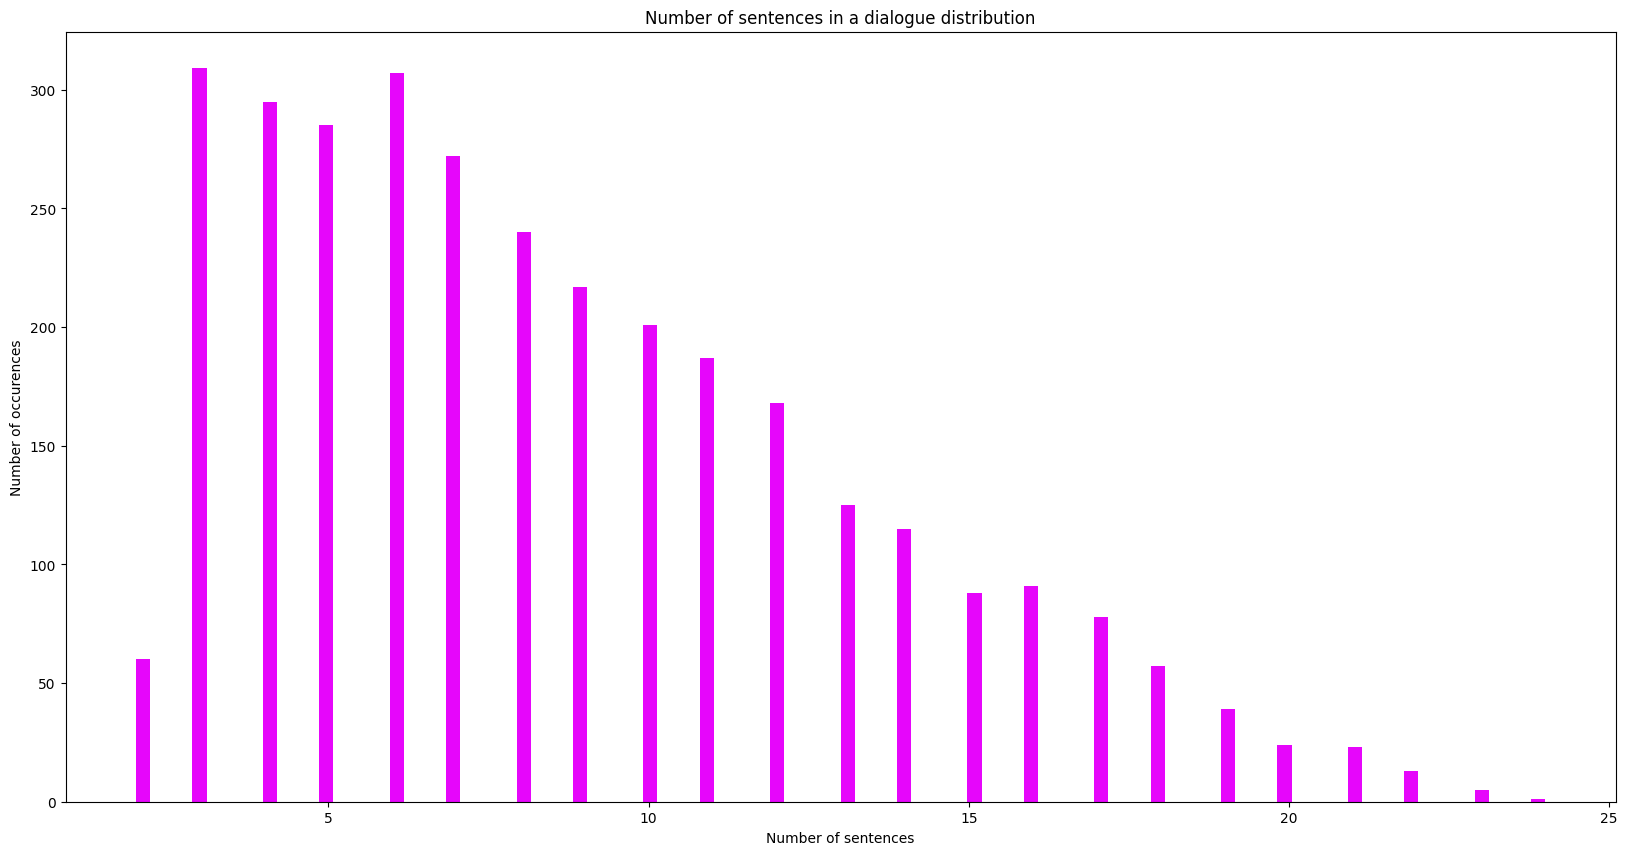

In [17]:
# get number of sentencese distribution
num_sentences = []
for index, row in df_train.iterrows():
    num_sentences.append(len(row["utterances"]))
print(f"Max number of sentences: {max(num_sentences)}")

# Plot number of sentences distribution
plt.figure(figsize=(20,10))
plt.hist(num_sentences, bins=100, color=set_color(1))
plt.title("Number of sentences in a dialogue distribution")
plt.xlabel("Number of sentences")
plt.ylabel("Number of occurences")
plt.show()

This plots show the distribution of the number of sentences per dialogue. We can see that the majority of the dialogues are composed of 10 sentences or less, with a few outliers.

This result while not being useful for the models hyperparameters, it is useful to understand the data and the task, more specifically the fact that the dialogues are short and that the models will have to learn from a small number of sentences. Also, the fact that the dialogues are short made us question the usefulness of the context in the task, as the context is usually used to understand the meaning of the sentence, but in this case the sentences are short and the meaning is usually clear from the sentence itself.

For further tasks we copied the dataframes in order to not modify the original ones.

In [18]:
bert_train = df_train.copy()
bert_val = df_val.copy()
bert_test = df_test.copy()

After many trials with models that tried to use the whole utterance as input, we decided to split the utterances into sentences and use the sentences as input for the models. This decision was made because the models were not able to learn from the whole utterance, as the utterances were too long and the models were not able to learn from them. Also, even with "Teacher Forcing", the resuts were not good. These trials are not reported in the notebook as they are not pertinent to the current models but they are discussed in the report.

In [19]:
def splitter_bert(df):
    columns = ["label", "sentence", "trigger", "dialogue"]
     # split the utteracnes into sentences with their corresponding labels
    new_df = pd.DataFrame(columns=columns)
    for index, row in df.iterrows():
        for i in range(len(row["utterances"])):
            # We also split emotions and triggers while adding back the dialogue index which is the same for all the sentences in the same dialogue
            new_row = pd.DataFrame({"label": [row["emotions"][i]], "sentence": [row["utterances"][i]], "trigger": [row["triggers"][i]], "dialogue": [index]} )
            new_df = pd.concat([new_df, new_row], ignore_index=True)
    return new_df

In [20]:
# split train, val and test sets for BERT
bert_train = splitter_bert(bert_train)
bert_val = splitter_bert(bert_val)
bert_test = splitter_bert(bert_test)
print("Shape of train, val and test sets after splitting: ")
print(f"Train shape: {bert_train.shape}")
print(f"Val shape: {bert_val.shape}")
print(f"Test shape: {bert_test.shape}")
print("-------------------------------------------------------")
print("Example of a sample: ")
print(bert_train.iloc[0])

C:\Users\alepa\AppData\Local\Temp\ipykernel_17396\1202298155.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, new_row], ignore_index=True)


C:\Users\alepa\AppData\Local\Temp\ipykernel_17396\1202298155.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, new_row], ignore_index=True)
C:\Users\alepa\AppData\Local\Temp\ipykernel_17396\1202298155.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, new_row], ignore_index=True)


Shape of train, val and test sets after splitting: 
Train shape: (27846, 4)
Val shape: (3614, 4)
Test shape: (3540, 4)
-------------------------------------------------------
Example of a sample: 
label       neutral
sentence      Yeah.
trigger         0.0
dialogue       2883
Name: 0, dtype: object


In [21]:
bert_train.head(10) # show first 10 samples of the train set

,label,sentence,trigger,dialogue
0,neutral,Yeah.,0.0,2883
1,anger,"Look, these clowns are trying to take us for a...",0.0,2883
2,anger,And we're not a couple of suckers!,0.0,2883
3,neutral,"I hear ya, Mugsy!",0.0,2883
4,neutral,"But look, all these rooms are fine okay?",0.0,2883
5,anger,Can you just pick one so I can watch--have a p...,0.0,2883
6,neutral,"Okay,",0.0,2883
7,anger,Nothing! It's over! Dammit! This is regularly ...,0.0,2883
8,disgust,Can we turn the TV off? Okay? Do we really wan...,0.0,2883
9,anger,"Oh, I'm sorry, am I getting in the way of all ...",0.0,2883


We create dictionaries to map the one-hot encoded labels to the original labels and vice versa.

We also keep track of an integer index for the emotions.

In [22]:
# one hot encode the emotions
emotions_one_hot_dict = {
    "neutral": [1, 0, 0, 0, 0, 0, 0],
    "joy": [0, 1, 0, 0, 0, 0, 0],
    "surprise": [0, 0, 1, 0, 0, 0, 0],
    "sadness": [0, 0, 0, 1, 0, 0, 0],
    "anger": [0, 0, 0, 0, 1, 0, 0],
    "disgust": [0, 0, 0, 0, 0, 1, 0],
    "fear": [0, 0, 0, 0, 0, 0, 1]
}

In [23]:
# one hot encode the triggers
triggers_one_hot_dict = {
    0: [1, 0],
    1: [0, 1]
}

In [24]:
emotion_to_index = {
    "neutral": 0,
    "joy": 1,
    "surprise": 2,
    "sadness": 3,
    "anger": 4,
    "disgust": 5,
    "fear": 6
}

Now that every utterance is split into sentences, we can proceed by visualizing the distribution of the number of words per sentence.

Max sentence length: 327


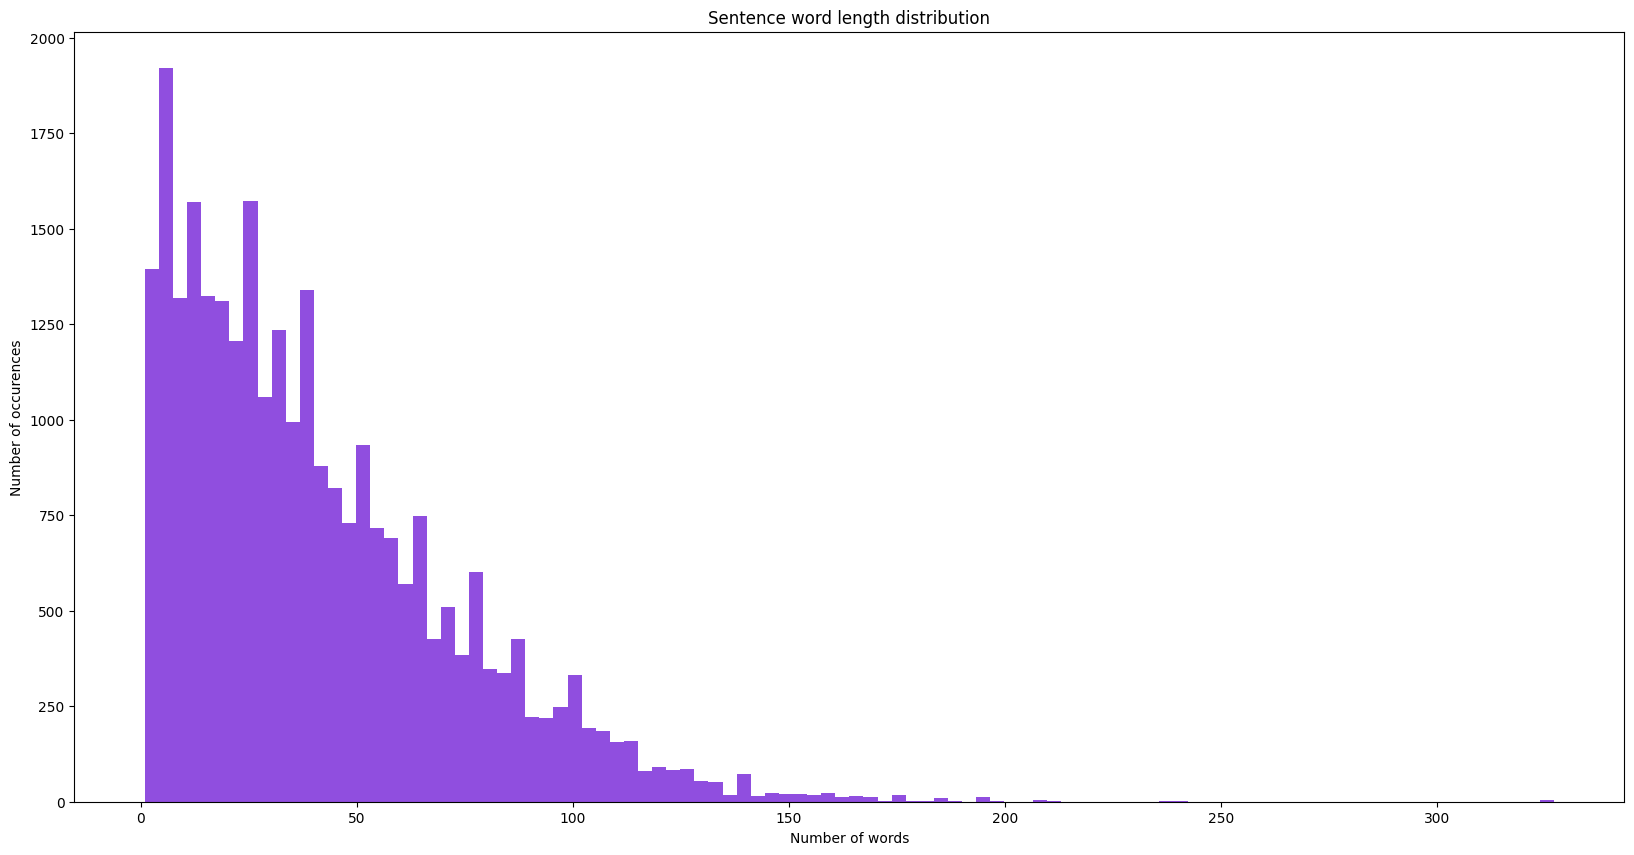

In [25]:
# plot sentence word length distribution
sentence_length = []
for index, row in bert_train.iterrows():
    sentence_length.append(len(row["sentence"]))
print(f"Max sentence length: {max(sentence_length)}")

plt.figure(figsize=(20,10))
plt.hist(sentence_length, bins=100, color=set_color(1))
plt.title("Sentence word length distribution")
plt.xlabel("Number of words")
plt.ylabel("Number of occurences")
plt.show()

As we can see from the plot, the majority of the sentences have a length of 10, wuth a few outliers. This is useful as it helps us decide the maximum length of the padding for the sentences.

As we use a BeRT uncased model its tokenizer will do all the preprocessing for us, so we do not need to do any preprocessing on the sentences. We need to only define hyperparameters such as the maximum length of the sentences and the batch size.

In [26]:
MODEL_NAME = 'bert-base-uncased'
#MODEL_NAME = "prajjwal1/bert-tiny"

MAX_LEN = 360 # To be safe even though the max length is 327
BATCH_SIZE = 1 # can be increased if memory allows it
EPOCHS = 5
LEARNING_RATE = 2e-05
OUT_CHANNELS = 768 if "base" in  MODEL_NAME else 128 #128 if "tiny" 1024 if "base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

BeRT models need custom datasets and dataloaders, so we define them as follows:

For the dataset we tokenize the sentences and pad them to the maximum length while also passing the target emotion and trigger label one-hot encoded.

Dialogue index is also returned as it is needed for the evaluation phase.

In [27]:
class CustomDataset(Dataset):

    def __init__(self, data, tokenizer, max_len, test_flag = False):
        self.tokenizer = tokenizer
        self.data = data
        self.text = data.sentence
        self.emotions = data.label
        self.max_len = max_len
        self.test_flag = test_flag
        self.triggers = data.trigger
        self.dialogue = data.dialogue

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        #speakers = row["speakers"]
        text = row["sentence"]
        emotions = row["label"]
        trigger = row["trigger"]
        dialogue = row["dialogue"]
        target_emotion = emotions_one_hot_dict[emotions] #+ [triggers[-1]] # trigger is float while emotions are one hot encoded but as integers IN CASE OF ERROR CHECK THIS
        target_trigger = triggers_one_hot_dict[trigger]


        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
        )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'label': torch.tensor(target_emotion, dtype=torch.float),
            'trigger': torch.tensor(target_trigger, dtype=torch.float),
            'dialogue': dialogue
        }

For the dataloader we simply use the default one.

In [28]:
train_dataset = CustomDataset(bert_train, tokenizer, MAX_LEN)
val_dataset = CustomDataset(bert_val, tokenizer, MAX_LEN, test_flag=True)
test_dataset = CustomDataset(bert_test, tokenizer, MAX_LEN, test_flag=True)

# Definiition of the Dataloader that will feed the data in batches to the neural network for suitable training and processing.
training_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Example of a tokenized and padded sentence:

In [29]:
train_dataset[0]

{'input_ids': tensor([ 101, 3398, 1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0, 

## Model definitions:


As we present two different macro type of models, we will define the models in two different ways. For the baseline models we simply use dummy classifiers with random uniform and majority strategies. For the BeRT models we use the BeRT architecture with an additional multihead classifier layers.

Defining the dummy classifier for emotions and triggers:

In [30]:
dummy_clf_majority_emotions = DummyClassifier(strategy="most_frequent")
dummy_clf_random_emotions = DummyClassifier(strategy="uniform")

dummy_clf_majority_triggers = DummyClassifier(strategy="most_frequent")
dummy_clf_random_triggers = DummyClassifier(strategy="uniform")

Defining the BeRT model for emotions and triggers:

The model is simply composed by BeRT, which functions as an encoder, and a multihead classifier. We decided on multihead classifier as it is a simple and effective way to classify the emotions and triggers separately, as the two tasks are related but not the same. (Previous trials with a single classifier for both tasks did not yield good results)

The two classifiers are composed by a dropout layer, to avoid overfitting, and a linear layer in order to classify the emotions and triggers.

In [31]:
class BERTClass(torch.nn.Module):
    def __init__(self,model):
        super(BERTClass, self).__init__()
        self.l1 = transformers.AutoModel.from_pretrained(model, return_dict=False)
        # Emotions
        self.l2 = torch.nn.Dropout(p=0.3)
        self.l3 = torch.nn.Linear(OUT_CHANNELS, 7)
        # Triggers
        self.l4 = torch.nn.Dropout(p=0.3)
        self.l5 = torch.nn.Linear(OUT_CHANNELS, 2)

    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_emotions = self.l2(output_1)
        output_emotions = self.l3(output_emotions)
        output_trigger = self.l4(output_1)
        output_trigger = self.l5(output_trigger)
        return output_emotions, output_trigger

In order to use the "Frozen" model we simply freeze the BeRT encoder and train only the multihead classifier.

In [32]:
model = BERTClass(MODEL_NAME)

# FROZEN BERT

for name, param in model.named_parameters():
     if name.startswith("l1"): # choose whatever you like here
        param.requires_grad = False


model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

## Evaluation metrics:

Here we define the evaluation metrics used for the models.

### Baseline models:

Evaluation function that returns the classification report:

In [33]:
def evaluate(Y_test, Y_pred):
    report = classification_report(Y_test, Y_pred, zero_division=0)
    return report

### BeRT models:

In order to evaluate the BeRT models we use the same metrics as the baseline models, mainly focusing on the weighted average F1 score.

One difference is that we also try to rebalance the classes by using the class weights in the loss function. This is done in order to see if the models can learn better from the data and thus improve the results.

We do this for both the emotions and the triggers.

In [34]:
#compute class weights based on distribution of classes in training set

y_train = []
for index, row in df_train.iterrows():
    for i in range(len(row["utterances"])):
        y_train.append(row["emotions"][i])
class_weights_emotions = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
print(f"Class weights: {class_weights_emotions}")
class_weights_emotions = torch.tensor(class_weights_emotions, dtype=torch.float)

Class weights: [1.26526718 4.83353584 4.59353349 0.8002414  0.32481424 1.930131
 1.06534547]


In [35]:
y_train = []
for index, row in df_train.iterrows():
    for i in range(len(row["utterances"])):
        y_train.append(row["triggers"][i])
class_weights_triggers = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
print(f"Class weights: {class_weights_triggers}")
class_weights_triggers = torch.tensor(class_weights_triggers, dtype=torch.float)

Class weights: [0.59428889 3.15142598]


Here is the custom loss function:

As we use a multihead classifier, we need to define the loss function for both the emotions and the triggers. 

Emotions loss function: cross entropy loss with class weights.
Triggers loss function: binary cross entropy loss with class weights.

The overall loss is the sum of the two losses.

In [36]:
def compute_loss(output_emotion, output_trigger, targets_emotion, targets_trigger):
    label_emotion = targets_emotion
    label_trigger = targets_trigger
    # compute custom loss 
    loss_fct_emo = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights_emotions).to(device))
    loss = loss_fct_emo(output_emotion, label_emotion)
    loss_fct_targ = torch.nn.BCEWithLogitsLoss(weight=torch.tensor(class_weights_triggers).to(device))
    loss += loss_fct_targ(output_trigger, label_trigger)
    return loss

We also define the inference function for the BeRT models:

For the emotions we use the argmax function to get the most probable emotion from the output of the model. For the triggers we use a sigmoid function to get the most probable trigger from the output of the model.

In [37]:
def inference(model, test_load):
    model.eval()
    fin_targets_emotion = []
    fin_outputs_emotion = []
    fin_targets_trigger = []
    fin_outputs_trigger = []

    dialogue_lengths = []

    current_dialogue = test_load.dataset.data.iloc[0]["dialogue"]
    length_current_dialogue = 0

    with torch.no_grad():
        for batch, data in enumerate(test_load, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            target_emotion = data['label'].to(device, dtype = torch.float)
            target_trigger = data['trigger'].to(device, dtype = torch.float)
            dialogue = data['dialogue']
            output_emotion, output_trigger = model(ids, mask, token_type_ids)
            
            if dialogue == current_dialogue:
                length_current_dialogue += 1
            else:
                dialogue_lengths.append(length_current_dialogue)
                length_current_dialogue = 1
                current_dialogue = dialogue

            fin_targets_emotion.extend(torch.argmax(target_emotion, axis=1).cpu().detach().numpy().tolist())
            fin_outputs_emotion.extend(torch.argmax(output_emotion, axis=1).cpu().detach().numpy().tolist())
            fin_outputs_trigger.extend(torch.sigmoid(output_trigger).cpu().detach().numpy().tolist())
        
    return fin_outputs_emotion, fin_targets_emotion, fin_outputs_trigger, dialogue_lengths

The trigger_max function is used to get the most probable trigger from the output of the model.

In [38]:
def trigger_max(outputs):
    temp = []
    for elem in outputs:
        if elem[0] > elem[1]:
            temp.append(0)
        else:
            temp.append(1)
    
    return temp

The RMSE function is used to calculate the root mean squared error between the predicted and the true trigger in order to find the standard deviation of the predictions.

In [39]:
from sklearn.metrics import mean_squared_error

def get_rmse(targets, outputs):
    return mean_squared_error(targets, outputs, squared=False)

## Training and evaluation:

Training and evaluation of the baseline classifiers fitted on the training set:

In [40]:
# Emotions baseline
dummy_clf_majority_emotions.fit(x_train_base, y_train_emotions)
dummy_clf_random_emotions.fit(x_train_base, y_train_emotions)

y_pred_majority_emotions = dummy_clf_majority_emotions.predict(x_test_base)
y_pred_random_emotions = dummy_clf_random_emotions.predict(x_test_base)
print("Majority classifier for emotions: \n")
print(evaluate(y_test_emotions, y_pred_majority_emotions))
print("-------------------------------------------------------")
print("Random classifier for emotions: \n")
print(evaluate(y_test_emotions, y_pred_random_emotions))
print("-------------------------------------------------------")

# Triggers baseline
dummy_clf_majority_triggers.fit(x_train_base, y_train_triggers)
dummy_clf_random_triggers.fit(x_train_base, y_train_triggers)

y_pred_majority_triggers = dummy_clf_majority_triggers.predict(x_test_base)
y_pred_random_triggers = dummy_clf_random_triggers.predict(x_test_base)
print("Majority classifier for triggers: \n")
print(evaluate(y_test_triggers, y_pred_majority_triggers))
print("-------------------------------------------------------")
print("Random classifier for triggers: \n")
print(evaluate(y_test_triggers, y_pred_random_triggers))

Majority classifier for emotions: 

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       392
     disgust       0.00      0.00      0.00       100
        fear       0.00      0.00      0.00       132
         joy       0.00      0.00      0.00       676
     neutral       0.42      1.00      0.59      1480
     sadness       0.00      0.00      0.00       291
    surprise       0.00      0.00      0.00       469

    accuracy                           0.42      3540
   macro avg       0.06      0.14      0.08      3540
weighted avg       0.17      0.42      0.25      3540

-------------------------------------------------------
Random classifier for emotions: 

              precision    recall  f1-score   support

       anger       0.14      0.19      0.16       392
     disgust       0.03      0.16      0.05       100
        fear       0.04      0.15      0.06       132
         joy       0.19      0.14      0.17       676
     n

As we can see from the results, the random uniform strategy performs poorly on both the emotions and the triggers, while the majority strategy performs better on the emotions and on the triggers.

We strongly believe that the majority strategy performs better on the triggers because the data is imbalanced, with the 0 class being the most represented and the 1 class being the least represented. This could lead to problems during the training phase, as the model could be biased towards the 0 class. Same thing for the emotions.

### BeRT model:

First we define the optimizer and the scheduler for the BeRT model. As an optimizer we use Adam as we prefer it over others. As a scheduler we use a linear scheduler with warmup, as it is the one that gave us the best results.

In [41]:
optimizer = torch.optim.Adam(params = model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=(0.1*(len(training_loader))*EPOCHS), num_training_steps=len(training_loader)*EPOCHS)

The training loop for the BeRT model is defined as follows:

We train the model for a number of epochs, in this case 5, and we evaluate it after each epoch. We also save the model with the best results. 

As we are currently using a batch size of 1 we only present the result every 5000 steps, just for visualization purposes.

In [42]:
def train():
    size = len(training_loader.dataset)
    model.train()
    for batch,data in enumerate(training_loader, 0):
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        target_emotion = data['label'].to(device, dtype = torch.float)
        target_trigger = data['trigger'].to(device, dtype = torch.float)
        
        output_emotion, output_trigger = model(ids, mask, token_type_ids)
        loss = compute_loss(output_emotion, output_trigger, target_emotion, target_trigger)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if batch%5000==0:
            current =  batch * len(data['input_ids'])
            print(f"Train loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

Validation is done on the validation set and is similar to the training loop, with the difference that we do not update the weights of the model.

In [43]:
def validation(epoch, val_loss_min_input):
    num_batches = len(val_loader)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch, data in enumerate(val_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            target_emotion = data['label'].to(device, dtype = torch.float)
            target_trigger = data['trigger'].to(device, dtype = torch.float)

            output_emotion, output_target = model(ids, mask, token_type_ids)
            val_loss += compute_loss(output_emotion, output_target, target_emotion, target_trigger).item()

        val_loss /= num_batches
        #outputs, targets = fin_outputs, fin_targets
        print(f"\nValidation loss: {val_loss:>8f}.")
        ## TODO: save the model if validation loss has decreased
        if val_loss <= val_loss_min_input:
            #create checkpoint variable and add important data
            if epoch > 0:
                print('Validation loss decreased ({:.8f} --> {:.8f}).  Saving model ...'.format(val_loss_min_input, val_loss))
            else: print('Saving model ...')
            # save best moel
            torch.save(model.state_dict(), "model_bert_standard_project.pth")
            print("Saved PyTorch Model State to model.pth\n")
            val_loss_min_input = val_loss

    return val_loss_min_input

BeRT model training:

In [44]:
val_loss_min_st = np.inf
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train()
    val_loss_min_st = validation(epoch, val_loss_min_st)

Epoch 1
-------------------------------


C:\Users\alepa\AppData\Local\Temp\ipykernel_17396\3149351706.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_fct_emo = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights_emotions).to(device))
C:\Users\alepa\AppData\Local\Temp\ipykernel_17396\3149351706.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_fct_targ = torch.nn.BCEWithLogitsLoss(weight=torch.tensor(class_weights_triggers).to(device))


Train loss: 3.450503  [    0/27846]


Train loss: 1.803745  [ 5000/27846]
Train loss: 4.636930  [10000/27846]
Train loss: 1.508262  [15000/27846]
Train loss: 2.066859  [20000/27846]
Train loss: 2.043662  [25000/27846]

Validation loss: 3.723689.
Saving model ...
Saved PyTorch Model State to model.pth

Epoch 2
-------------------------------
Train loss: 2.430909  [    0/27846]
Train loss: 1.597644  [ 5000/27846]
Train loss: 4.266874  [10000/27846]
Train loss: 1.821557  [15000/27846]
Train loss: 1.514630  [20000/27846]
Train loss: 1.489734  [25000/27846]

Validation loss: 3.602525.
Validation loss decreased (3.72368855 --> 3.60252501).  Saving model ...
Saved PyTorch Model State to model.pth

Epoch 3
-------------------------------
Train loss: 1.803339  [    0/27846]
Train loss: 1.845284  [ 5000/27846]
Train loss: 4.820958  [10000/27846]
Train loss: 2.057179  [15000/27846]
Train loss: 1.237401  [20000/27846]
Train loss: 1.959157  [25000/27846]

Validation loss: 3.538085.
Validation loss decreased (3.60252501 --> 3.53808480).

Evaluation of the BeRT model:

In order to evaluate the BeRT model we use the same metrics as the baseline models, but propose two different approaches. The first approach is to use the model as it is, with the dialogues unrolled into sentences. The second approach is to consider results based on the dialogues, as to get a more realistic evaluation of the model.

### Unrolled sentences:

We get the results for the emotions and the triggers separately.

In [45]:
outputs_emotion, targets_emotion, outputs_trigger, dialogue_lengths = inference(model, test_loader)
targets_trigger = bert_test["trigger"].tolist()
trigger_max_pred = trigger_max(outputs_trigger)

In [46]:
report_triggers = classification_report(targets_trigger, trigger_max_pred,zero_division=0)
report_emotions = classification_report(targets_emotion, outputs_emotion, target_names=emotion_to_index.keys(), zero_division=0)
print("Report for triggers: \n")
print(report_triggers)
print("-------------------------------------------------------")
print("Report for emotions: \n")
print(report_emotions)

Report for triggers: 

              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91      2961
         1.0       0.00      0.00      0.00       579

    accuracy                           0.84      3540
   macro avg       0.42      0.50      0.46      3540
weighted avg       0.70      0.84      0.76      3540

-------------------------------------------------------
Report for emotions: 

              precision    recall  f1-score   support

     neutral       0.72      0.43      0.54      1480
         joy       0.28      0.75      0.41       676
    surprise       0.34      0.61      0.44       469
     sadness       0.00      0.00      0.00       291
       anger       0.00      0.00      0.00       392
     disgust       0.00      0.00      0.00       100
        fear       0.00      0.00      0.00       132

    accuracy                           0.41      3540
   macro avg       0.19      0.26      0.20      3540
weighted avg       0.40      

In [47]:
rmse_triggers = get_rmse(targets_trigger, trigger_max_pred)
print(f"RMSE for triggers: {rmse_triggers}")

rmse_emotions = get_rmse(targets_emotion, outputs_emotion)
print(f"RMSE for emotions: {rmse_emotions}")

RMSE for triggers: 0.4044246802977018
RMSE for emotions: 1.815734742567656


As we can see from the results, the model performs way better than the baseline models. One important thing to notice is that is can actually classify even emotions that are hardly represented in the data, such as disgust, which is something that neither the baseline models nor previous trials without class weights were able to do.

The santandard deviation of the emotion prediction is higher than the one of the trigger prediction, which is expected as the emotions are more complex than the triggers.

Further result exploration is done in the last part of the notebook.

### Sequences of dialogues: 

Instead of computing single predictions and metrics we also consider the fact that single sentences are part of a dialogue.

Here we make use of the dialogue index that we saved during the dataset creation phase.

In [48]:
def get_dialogue_preds(outputs_emotion, targets_emotion, outputs_trigger, targets_trigger, dialogue_lengths):
    current_index = 0
    dialogue_predictions_emotions = []
    dialogue_targets_emotions = []
    dialogue_predictions_triggers = []
    dialogue_targets_triggers = []
    for length in dialogue_lengths:
        dialogue_predictions_emotions.append(outputs_emotion[current_index:current_index+length])
        dialogue_targets_emotions.append(targets_emotion[current_index:current_index+length])
        dialogue_predictions_triggers.append(outputs_trigger[current_index:current_index+length])
        dialogue_targets_triggers.append(targets_trigger[current_index:current_index+length])
        current_index += length
    
    return dialogue_predictions_emotions, dialogue_targets_emotions, dialogue_predictions_triggers, dialogue_targets_triggers

We compute the predictions for each sentence and then we group them by dialogue index. We also compute emotion and trigger predictions for each dialogue separately.

In [49]:
dialogue_predictions_emotions, dialogue_targets_emotions, dialogue_predictions_triggers, dialogue_targets_triggers = get_dialogue_preds(outputs_emotion, targets_emotion, trigger_max_pred, targets_trigger, dialogue_lengths)

In [50]:
def f1_score_per_dialogue(dialogue_predictions_emotions, dialogue_targets_emotions, dialogue_predictions_triggers, dialogue_targets_triggers):
    f1_scores_emotions = []
    f1_scores_triggers = []
    for i in range(len(dialogue_predictions_emotions)):
        f1_scores_emotions.append(f1_score(dialogue_targets_emotions[i], dialogue_predictions_emotions[i], average='macro'))
        f1_scores_triggers.append(f1_score(dialogue_targets_triggers[i], dialogue_predictions_triggers[i], average='macro'))
    return f1_scores_emotions, f1_scores_triggers

In order to compute a dialogue prediction we use simply use the mean of the predictions of the sentences that compose the dialogue.

In [51]:
f1_scores_emotions, f1_scores_triggers = f1_score_per_dialogue(dialogue_predictions_emotions, dialogue_targets_emotions, dialogue_predictions_triggers, dialogue_targets_triggers)
print(f"Average F1 score for emotions per dialogue: {np.mean(f1_scores_emotions)}")
print(f"Average F1 score for triggers per dialogue: {np.mean(f1_scores_triggers)}")

Average F1 score for emotions per dialogue: 0.2798013436911914
Average F1 score for triggers per dialogue: 0.47589459865140393


In [52]:
def rmse_per_dialogue(f1_scores):
    rmse_scores = []
    for i in range(len(f1_scores)):
        rmse_scores.append(np.sqrt(((f1_scores[i] - np.mean(f1_scores)) ** 2)))
    return rmse_scores

In [53]:
rmse_scores_emotions = rmse_per_dialogue(f1_scores_emotions)
rmse_scores_triggers = rmse_per_dialogue(f1_scores_triggers)

print(f"RMSE for emotions per dialogue: {np.mean(rmse_scores_emotions)}")
print(f"RMSE for triggers per dialogue: {np.mean(rmse_scores_triggers)}")

RMSE for emotions per dialogue: 0.13383732709943583
RMSE for triggers per dialogue: 0.08364558094501669


As for these results we see that the average f1 score is lower than the one of the unrolled sentences. We believe that is due to the fact that some dialogues are higly unbalanced, thus probably leading to a lower f1 score. The same phenomenon happens for the trigger labels. We explore this further in the last part of the notebook.

The standard deviation improves though, which could mean that the inbalance of the dialogues is both a "good" and a "bad" thing. It is good because if we aggregate the predictions of the sentences we get a more balanced prediction towards the majority class, but it is bad because the model has a harder time learning from the data.

## Further results exploration:

In [54]:
import gc

model = None
del model

with torch.no_grad():
    torch.cuda.empty_cache()

gc.collect()

40